### CS 178: Machine Learning &amp; Data Mining

# Final Project: CNN on Facial Expressions


In [30]:
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
from tqdm import tqdm

# Image processing
#import imageio
import cv2
#import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
# import seaborn as sns

# ML, statistics
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#### 1.2 Loading in legend 

In [12]:
# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy= False

## downloading csv label file
## facial_df = facial dataframe
labels_url = "https://raw.githubusercontent.com/muxspace/facial_expressions/master/data/legend.csv"
facial_df = pd.read_csv(labels_url)
if toy:
    facial_df = facial_df.sample(500)

facial_df.head() #head returns first [.head(n)] n values

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral


##### Preprocessing
Emotion labels are case-sensitive. So, need to preprocess and make them all the same.

In [13]:
facial_df['emotion'] = facial_df['emotion'].str.lower()
facial_labels = facial_df.emotion.unique()

##### Visualizing Labels

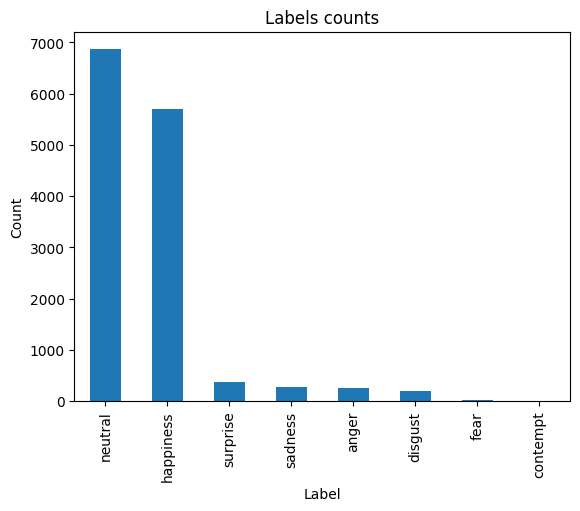

In [14]:
facial_df.emotion.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

##### Visualizing Images (Basic)

../CS 178/cs178_facial_expressions/images/David_Donohue_0001.jpg


AttributeError: 'NoneType' object has no attribute 'shape'

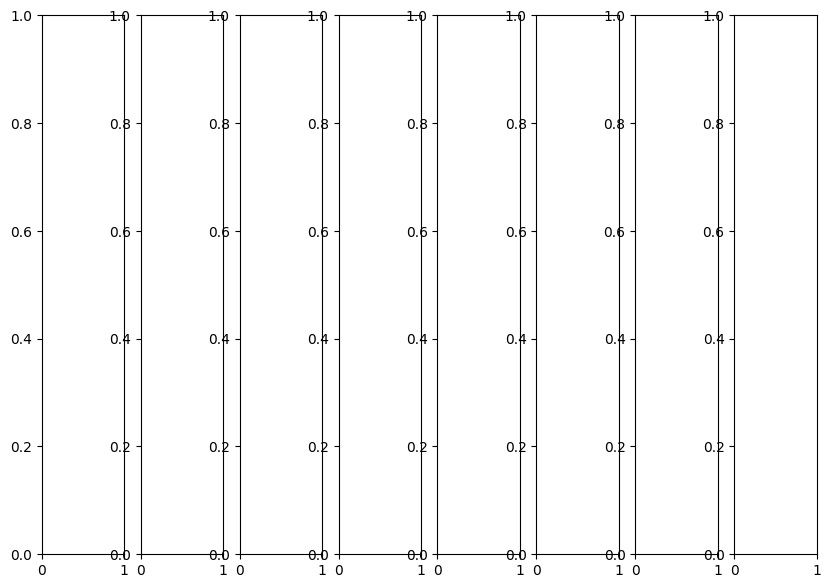

In [16]:
from io import BytesIO
from PIL import Image
import urllib



class ImageViewer:
    def read_img(self,id, folder="images"):
        """
        Read image by it's image name [id]
        """
        file = "../CS 178/cs178_facial_expressions/" + folder + "/" + id
        print(file)
        im=cv2.imread(str(file),  cv2.IMREAD_GRAYSCALE)
        return im

    def draw_sample_images(self):
        """
        Draws images for each label.
        labels: ['neutral' 'happiness' 'sadness' 'surprise' 'anger' 'disgust' 'fear' 'contempt']
        """
        ncols=8
        fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(10,7))
        
        labels=  ['neutral', 'happiness', 'sadness', 'surprise', 'anger' ,'disgust', 'fear', 'contempt']

        for col in range(0,ncols):
            try:
                sample = facial_df[facial_df['emotion']==labels[col]]['image'].sample(1).values
            except ValueError:
                continue
            
            im=self.read_img(sample[0])
            
            # [makes images appear the same size] Calculate the aspect ratio to maintain the original image proportions
            aspect_ratio = im.shape[1] / im.shape[0]
            ax[col].imshow(im, cmap="gray", vmin=0, vmax=255, extent=[0, 1, 0, 1 * aspect_ratio])
            

            ax[col].set_title(labels[col])
            ax[col].axis('off')  # Turn off axis labels
        fig.tight_layout()
        
testing = ImageViewer()
testing.draw_sample_images()



## Playing with sift

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


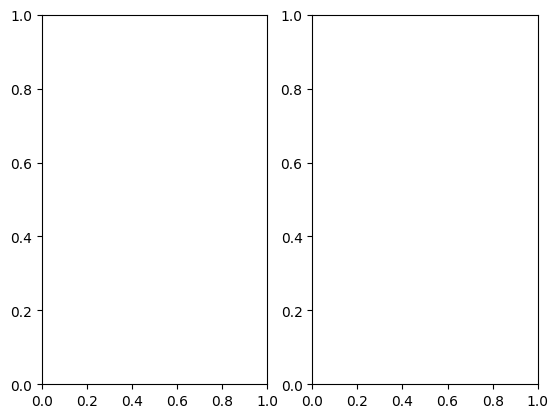

In [17]:
fig, ax =  plt.subplots(1, 2) # , figsize=(10,7))

#reading image
img = cv2.imread('../CS 178/cs178_facial_expressions/images/Milan_Kucan_0001.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)



img=cv2.drawKeypoints(gray,kp,img)# ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #flags: shows circle of size of kp and will show it's orientation
cv2.imwrite('sift_keypoints.jpg',img)
ax[0].imshow(img)

img=cv2.drawKeypoints(gray,kp,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #flags: shows circle of size of kp and will show it's orientation
cv2.imwrite('sift_keypoints.jpg',img)
ax[1].imshow(img)
# gives us data we can use des: numpy array of shape (num of kp) x 128
kp,des = sift.compute(gray,kp)

### Comparing Images w/ SIFT

In [18]:
avg_matches = 0
total = 0
iter = 1

while True:
    sample = facial_df[facial_df['emotion']=="happiness"]['image'].sample(2).values
    
    img1 = "../CS 178/cs178_facial_expressions/images/" + str(sample[0])
    img2 = "../CS 178/cs178_facial_expressions/images/" + str(sample[1])
    
    #reading images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    #sift
    sift = cv2.SIFT_create() # creates a sift object
    
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    
    
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    if len(matches) > 40:
        img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
        plt.title(f"{sample[0]} vs {sample[1]}")
        plt.imshow(img3),plt.show()
        
        print("num of matches:", len(matches))
    
    total += len(matches)

    if iter == 50:
        avg_matches = total/iter
        break
    iter += 1
print(avg_matches)

# over 50
# test 1: avg = 21.94
# test 2: avg = 22.9
# test 3: avg = 24

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [19]:
iter = 0
while True:
    iter += 1
    if iter == 5:
        break
        
    sample = facial_df[facial_df['emotion']=="happiness"]['image'].sample(1).values
    sample2 = facial_df[facial_df['emotion']=="neutral"]['image'].sample(1).values
    
    img1 = "../CS 178/cs178_facial_expressions/images/" + str(sample[0])
    img2 = "../CS 178/cs178_facial_expressions/images/" + str(sample2[0])
    
    #reading images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    #sift
    sift = cv2.SIFT_create() # creates a sift object
    
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    
    
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
    plt.title(f"happiness ({sample[0]}) vs neutral ({sample2[0]})")
    plt.imshow(img3),plt.show()
    
    print("num of matches:", len(matches))
    

# over 50
# test 1: avg = 21.94
# test 2: avg = 22.9
# test 3: avg = 24

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [26]:
# Paths to your directories
images_directory = 'facial_expressions-master/images'   # images
data_directory = 'facial_expressions-master/data'       # data

# Load legend.csv file
csv_file_path = os.path.join(data_directory, 'legend-fixed.csv')
data = pd.read_csv(csv_file_path)

# Display the first few rows of the CSV data to understand its structure
print(data.head())

# Load images and corresponding labels
image_data = []
labels = []

for index, row in tqdm(data.iterrows(), total=len(data)):
    image_name = row['image']  # Assuming 'Image' is the column containing image names
    image_path = os.path.join(images_directory, image_name)
    
    with Image.open(image_path) as image:
        
        if image.size == (350, 350):  # Assuming you want images with dimensions 350x350
            # Append image data and label to lists
            image_data.append(image.copy())  # Make a copy to keep the original file closed
            labels.append(row['emotion'])
        # image.close()

  user.id                            image   emotion
0     628  facial-expressions_2868588k.jpg     anger
1     628  facial-expressions_2868585k.jpg  surprise
2     628  facial-expressions_2868584k.jpg   disgust
3     628  facial-expressions_2868582k.jpg      fear
4   dwdii           Aaron_Eckhart_0001.jpg   neutral


100%|███████████████████████████████████████████████████████████████████████████| 13690/13690 [01:12<00:00, 188.19it/s]


In [37]:
# Example: Convert each PIL image to a numpy array and flatten it
# Note: This example assumes grayscale images; adjust accordingly for color images
image_arrays = [np.array(image).flatten() for image in image_data]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_arrays, labels, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
# logreg = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
# logreg.fit(X_train, y_train)

# # Evaluate the model
# accuracy = logreg.score(X_test, y_test)
# print(f"Accuracy of Logistic Regression: {accuracy:.2f}")

In [38]:
filter = 64
kernel = (3,3)
img_width = 500
img_height = 500
img_channels = 1
num_classes = 8
def build_cnn(filter, kernel, img_width, img_height, img_channels, num_classes):
    # Define the CNN model
    model = Sequential()
    
    # Adjust input shape according to your data [height, width, channels]
    model.add(Conv2D(filter, kernel, activation='relu', input_shape=(img_width, img_height, img_channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filter, kernel, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filter, kernel, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # Number of neurons in the dense layer
    
    # Adjust the number of units in the output layer for the number of classes [num_classes]
    model.add(Dense(num_classes, activation='softmax'))  # For classification tasks
    
    # Compile the model with appropriate loss and optimizer
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Choose appropriate loss function and metrics
    
    # Display the model summary
    model.summary()
    
    return model

In [41]:
print(X_train.shape)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = X_train.reshape(-1, img_width, img_height, img_channels)
X_test = X_test.reshape(-1, img_width, img_height, img_channels)
batch_size = 32
epochs = 100
model = build_cnn(filter, kernel, img_width, img_height, img_channels, num_classes)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

(10212, 122500)


ValueError: cannot reshape array of size 1250970000 into shape (500,500,1)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()